[Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I)


This notebook is about training word embeddings on the names.txt file, to come up with new names.

It is based on the paper [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) by Yoshua Bengio.



![Neural Architecture](images/NeuralArchitecture.png)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
delimiter = '.'

In [6]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[delimiter]=0
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [7]:
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [8]:
# build the dataset
block_size = 3 # aka context length: how many characters do we take to predict the next one?

In [9]:
# X is the input to the neural network
# Y are the labels
X, Y = [], []

In [10]:
[0]*block_size

[0, 0, 0]

In [11]:
for w in words[:5]:
    
    print(w)
    # [0] is the index for the delimiter we set above ... 
    # hence [0,0,0] run throught itos becomes ['.','.','.']
    context = [0]*block_size
    for ch in w + delimiter :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
    print('')

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

ava
... ---> a
..a ---> v
.av ---> a
ava ---> .

isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .

sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .



In [12]:
# repeat the above, but with a larger block_size, just to show the differenct
block_size = 10
X, Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0]*block_size
    for ch in w + delimiter :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
    print('')

emma
.......... ---> e
.........e ---> m
........em ---> m
.......emm ---> a
......emma ---> .

olivia
.......... ---> o
.........o ---> l
........ol ---> i
.......oli ---> v
......oliv ---> i
.....olivi ---> a
....olivia ---> .

ava
.......... ---> a
.........a ---> v
........av ---> a
.......ava ---> .

isabella
.......... ---> i
.........i ---> s
........is ---> a
.......isa ---> b
......isab ---> e
.....isabe ---> l
....isabel ---> l
...isabell ---> a
..isabella ---> .

sophia
.......... ---> s
.........s ---> o
........so ---> p
.......sop ---> h
......soph ---> i
.....sophi ---> a
....sophia ---> .



In [13]:
# now do everything for realz this time ... 
# which is to build out X and Y
# from all the names in words.
block_size = 3
X, Y = [], []
for w in words:
    
    # print(w)
    context = [0]*block_size
    for ch in w + delimiter :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

In [14]:
X[:5]

[[0, 0, 0], [0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1]]

In [15]:
Y[:5]

[5, 13, 13, 1, 0]

In [16]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [17]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [18]:
noOfRecordsInTheInputDataSet = X.shape[0]

Now lets build the embedding lookup C which has a total of 27 characters.

In [19]:
# we will use a 2 dimensional embedding for every one of the 27 characters
embeddingWidth = 2
totalCharacters = len(stoi)
C = torch.rand((totalCharacters,embeddingWidth))
C

tensor([[0.8459, 0.4510],
        [0.9077, 0.5361],
        [0.6236, 0.7318],
        [0.0368, 0.9312],
        [0.2447, 0.4749],
        [0.6581, 0.4596],
        [0.7869, 0.8778],
        [0.4576, 0.3735],
        [0.2296, 0.8808],
        [0.7611, 0.3405],
        [0.1207, 0.1763],
        [0.5623, 0.3097],
        [0.4903, 0.6508],
        [0.3969, 0.6439],
        [0.0236, 0.9114],
        [0.6289, 0.2706],
        [0.4205, 0.2553],
        [0.2321, 0.7635],
        [0.0415, 0.9986],
        [0.1346, 0.0273],
        [0.8008, 0.5943],
        [0.8664, 0.7671],
        [0.9042, 0.9572],
        [0.3985, 0.5992],
        [0.8153, 0.9670],
        [0.7368, 0.8205],
        [0.8514, 0.7405]])

In [20]:
F.one_hot(torch.tensor(5), num_classes=totalCharacters)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [21]:
# this fails ... 
# F.one_hot(torch.tensor(5), num_classes=27) @ C

In [22]:
F.one_hot(torch.tensor(5), num_classes=totalCharacters).dtype

torch.int64

In [23]:
C.dtype

torch.float32

In [24]:
F.one_hot(torch.tensor(5), num_classes=totalCharacters).float() @ C

tensor([0.6581, 0.4596])

In [25]:
# the above operation is the same as ...
C[5]

tensor([0.6581, 0.4596])

In [26]:
C[[5, 6, 7]]

tensor([[0.6581, 0.4596],
        [0.7869, 0.8778],
        [0.4576, 0.3735]])

In [27]:
C[torch.tensor([5, 6, 7])]

tensor([[0.6581, 0.4596],
        [0.7869, 0.8778],
        [0.4576, 0.3735]])

In [28]:
C[:6]

tensor([[0.8459, 0.4510],
        [0.9077, 0.5361],
        [0.6236, 0.7318],
        [0.0368, 0.9312],
        [0.2447, 0.4749],
        [0.6581, 0.4596]])

In [29]:
C[[0, 1, 5, 13]]

tensor([[0.8459, 0.4510],
        [0.9077, 0.5361],
        [0.6581, 0.4596],
        [0.3969, 0.6439]])

In [30]:
X[:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [31]:
# so notice how we use X to index into C ...
C[X][:5]

tensor([[[0.8459, 0.4510],
         [0.8459, 0.4510],
         [0.8459, 0.4510]],

        [[0.8459, 0.4510],
         [0.8459, 0.4510],
         [0.6581, 0.4596]],

        [[0.8459, 0.4510],
         [0.6581, 0.4596],
         [0.3969, 0.6439]],

        [[0.6581, 0.4596],
         [0.3969, 0.6439],
         [0.3969, 0.6439]],

        [[0.3969, 0.6439],
         [0.3969, 0.6439],
         [0.9077, 0.5361]]])

In [32]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [33]:
emb[0]

tensor([[0.8459, 0.4510],
        [0.8459, 0.4510],
        [0.8459, 0.4510]])

Now let's construct the hidden layer, which is the first layer after the input layer in Figure 1. (the tanh layer)

W1 are the weights and the number of inputs into this layer will be 3x2=6, which is the product of the blocksize X embedding width.

In [34]:
noOfInputs = block_size * embeddingWidth
noOfNeurons = 100
W1 = torch.randn((noOfInputs, noOfNeurons))
W1.shape

torch.Size([6, 100])

In [35]:
b1 = torch.randn(noOfNeurons)
b1.shape

torch.Size([100])

Now remember we would like to multiply the inputs (the embeddings) by W1 and add b1, but the problem is the embeddings are stacked up in the tensor, so we can't simply multiply one by the other. We need to somehow concatonate the 3 embeddings for each input into a tensor of size 6.

h = emb @ W1 + b1

A brief look at the best way to reshape a tensor with a PyTorch [view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html), which `returns a new tensor with the same data as the self tensor but of a different shape.`

(The page [PyTorch interals](http://blog.ezyang.com/2019/05/pytorch-internals/) provides insights into what a view does with a tensor)



In [36]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [37]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [38]:
a.view(9,2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [39]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

So let's reshape the emb tensor to the desired shape.

In [40]:
emb.shape

torch.Size([228146, 3, 2])

In [41]:
emb.shape[0]

228146

In [42]:
emb.view(emb.shape[0], 6).shape

torch.Size([228146, 6])

In [43]:
emb.view(-1, 6).shape

torch.Size([228146, 6])

In [44]:
emb.view(emb.shape[0], noOfInputs).shape

torch.Size([228146, 6])

So now let's calculate h, the output for the hidden layer.

In [45]:
h = (emb.view(-1, noOfInputs) @ W1) + b1
h.shape

torch.Size([228146, 100])

In [46]:
# right ... don't forget tanh ...
h = torch.tanh((emb.view(-1, noOfInputs) @ W1) + b1)
h.shape

torch.Size([228146, 100])

Now let's look at the final layer, where we do the softmax.

The input width will be 100, as seen above, and the output width will be the total number of characters, which is 27.

In [47]:
totalCharacters

27

In [48]:
hiddenLayerOutputWidth = h.shape[-1]
hiddenLayerOutputWidth

100

In [49]:
W2 = torch.randn((hiddenLayerOutputWidth, totalCharacters))
W2.shape

torch.Size([100, 27])

In [50]:
b2 = torch.randn(totalCharacters)
b2.shape

torch.Size([27])

In [51]:
h.shape

torch.Size([228146, 100])

In [52]:
h @ W2

tensor([[-2.9066,  3.7294, -6.0789,  ...,  9.2548,  8.6371,  7.2790],
        [-3.7110,  5.0732, -4.3311,  ...,  9.1354,  7.1831,  6.8223],
        [-4.3943,  5.5123, -1.2914,  ...,  8.1199,  6.3306,  5.0580],
        ...,
        [-6.0486,  5.0618, -2.9038,  ...,  9.2050, 10.1232,  8.4187],
        [-6.2805,  5.1219, -4.4579,  ...,  8.8697, 10.5273,  8.3446],
        [-6.9839,  3.2903, -1.8279,  ...,  9.5842, 11.4665,  8.5596]])

In [53]:
h @ W2 + b2

tensor([[-3.7427,  4.7371, -5.6173,  ..., 10.2083,  9.3442,  8.5993],
        [-4.5472,  6.0810, -3.8695,  ..., 10.0889,  7.8902,  8.1426],
        [-5.2304,  6.5201, -0.8297,  ...,  9.0734,  7.0376,  6.3784],
        ...,
        [-6.8848,  6.0696, -2.4421,  ..., 10.1586, 10.8302,  9.7390],
        [-7.1166,  6.1297, -3.9963,  ...,  9.8232, 11.2343,  9.6650],
        [-7.8200,  4.2981, -1.3663,  ..., 10.5377, 12.1735,  9.8799]])

In [54]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [55]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

In [56]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

Notice how every row of prob will sum to 1.

In [57]:
prob[0].sum()

tensor(1.)

In [58]:
prob[234].sum()

tensor(1.0000)

In [59]:
Y.shape

torch.Size([228146])

In [60]:
Y[:16]

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0])

In [61]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [62]:
prob.shape

torch.Size([228146, 27])

In [63]:
noOfRecordsInTheInputDataSet

228146

In [64]:
prob[torch.arange(noOfRecordsInTheInputDataSet), Y]

tensor([3.8518e-06, 4.8436e-09, 2.8565e-08,  ..., 2.2371e-03, 3.8263e-03,
        4.0364e-11])

In [65]:
loss = -prob[torch.arange(noOfRecordsInTheInputDataSet), Y].log().mean()
loss

tensor(13.1361)

In [66]:
# ------------ now made respectable :) ---------------

Summary of a full network ...

In [67]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [68]:
print(f'noOfRecordsInTheInputDataSet => {noOfRecordsInTheInputDataSet}')
print(f'totalCharacters => {totalCharacters}')
print('')
print(f'block_size => {block_size}')
print(f'embeddingWidth => {embeddingWidth}')
print(f'noOfInputs => (block_size * embeddingWidth) = {noOfInputs}')
print('')
print(f'noOfNeurons (in the hidden layer)=> {noOfNeurons}')





noOfRecordsInTheInputDataSet => 228146
totalCharacters => 27

block_size => 3
embeddingWidth => 2
noOfInputs => (block_size * embeddingWidth) = 6

noOfNeurons (in the hidden layer)=> 100


In [69]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# The video hard codes these values, but I will use the 'live' numbers from above ...
# ... which actually are the same numbers!

# C = torch.randn((27, 10), generator=g)
# W1 = torch.randn((30, 200), generator=g)
# b1 = torch.randn(200, generator=g)
# W2 = torch.randn((200, 27), generator=g)
# b2 = torch.randn(27, generator=g)
# parameters = [C, W1, b1, W2, b2]


# C = torch.randn((27, 10), generator=g)
C = torch.randn((totalCharacters, embeddingWidth), generator=g)

W1 = torch.randn((noOfInputs, noOfNeurons), generator=g)
b1 = torch.randn(noOfNeurons, generator=g)

W2 = torch.randn((noOfNeurons, totalCharacters), generator=g)
b2 = torch.randn(totalCharacters, generator=g)

parameters = [C, W1, b1, W2, b2]

In [70]:
# this is the same as in the video
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [71]:
emb = C[X]
print(f'emb.shape => {emb.shape}')
h = torch.tanh(emb.view(-1, noOfInputs) @ W1 + b1)
logits = h @ W2 + b2

# the next 3 calculations can be replaced with the PyTorch
# cross_entropy function which is way more efficient 
# than doing it manually like we show here ...
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
print(f'noOfRecordsInTheInputDataSet => {noOfRecordsInTheInputDataSet}')
loss = -prob[torch.arange(noOfRecordsInTheInputDataSet), Y].log().mean()

loss
# run this any number of times, and you will get the same result
# tensor(19.5052)

emb.shape => torch.Size([228146, 3, 2])
noOfRecordsInTheInputDataSet => 228146


tensor(19.5052)

In [72]:
# replace with PyTorch cross_entropy
F.cross_entropy(logits, Y)

tensor(19.5052)

Summarize the above into a training loop ...

In [73]:
# ... right ... we forgot to do this 
for p in parameters:
    p.requires_grad = True

In [74]:
# Running this takes up 100% of all 8 cpus!
epochs = 10

for _ in range(epochs):
    
    # 1) forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, noOfInputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f'Training loss => {loss.item()}')

    # 2) backward pass
    # first set the gradients to zero ...
    for p in parameters:
        p.grad = None
    # then populate those gradients ...
    loss.backward()

    # 3) update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
# everytime we run this, the loss keeps going down 

Training loss => 19.505229949951172
Training loss => 17.084487915039062
Training loss => 15.776532173156738
Training loss => 14.833340644836426
Training loss => 14.002604484558105
Training loss => 13.253262519836426
Training loss => 12.57991886138916
Training loss => 11.983101844787598
Training loss => 11.470492362976074
Training loss => 11.05185604095459


Now let's work on training in batches, instead of using the entire input dataset on each epoch.

In [75]:
X.shape

torch.Size([228146, 3])

In [76]:
# replicate the code from above, but add ...

epochs = 10

for _ in range(epochs):
    
    # minibatch construct ...
    # generate batchSize array of ints between 0 and noOfRecordsInTheInputDataSet ...
    # Notice there is nothing to prevent us picking the same record more than once ...
    batchSize = 32
    ix = torch.randint(0,  noOfRecordsInTheInputDataSet, (batchSize,))
    
    # 1) forward pass
    emb = C[X[ix]] # Changed!
    h = torch.tanh(emb.view(-1, noOfInputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) # Changed!
    print(f'Training loss => {loss.item()}')

    # 2) backward pass
    # first set the gradients to zero ...
    for p in parameters:
        p.grad = None
    # then populate those gradients ...
    loss.backward()

    # 3) update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

Training loss => 8.429880142211914
Training loss => 8.969592094421387
Training loss => 8.090163230895996
Training loss => 11.032674789428711
Training loss => 11.685018539428711
Training loss => 8.31801700592041
Training loss => 9.405543327331543
Training loss => 10.273889541625977
Training loss => 8.432548522949219
Training loss => 8.645686149597168


We want to have a changing learning rate instead of a fixed learning rate ...

In [77]:
torch.linspace(0, 32, 4)

tensor([ 0.0000, 10.6667, 21.3333, 32.0000])

In [78]:
torch.linspace(0, 32, 8)

tensor([ 0.0000,  4.5714,  9.1429, 13.7143, 18.2857, 22.8571, 27.4286, 32.0000])

In [79]:
torch.linspace(0, 32, 10)

tensor([ 0.0000,  3.5556,  7.1111, 10.6667, 14.2222, 17.7778, 21.3333, 24.8889,
        28.4444, 32.0000])

In [80]:
torch.linspace(-3, 0, 10)

tensor([-3.0000, -2.6667, -2.3333, -2.0000, -1.6667, -1.3333, -1.0000, -0.6667,
        -0.3333,  0.0000])

In [81]:
# this code resets stuff so that we can re-run stuff fresh

epochs = 10000 # Changed!

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((totalCharacters, embeddingWidth), generator=g)
W1 = torch.randn((noOfInputs, noOfNeurons), generator=g)
b1 = torch.randn(noOfNeurons, generator=g)
W2 = torch.randn((noOfNeurons, totalCharacters), generator=g)
b2 = torch.randn(totalCharacters, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [82]:
lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [87]:
# replicate the code from above, but add learning rate stuff ...

# Changed!
lri = []
lossi = []

for i in range(epochs):  # Changed!
    
    # minibatch construct ...
    # generate batchSize array of ints between 0 and noOfRecordsInTheInputDataSet ...
    # Notice there is nothing to prevent us picking the same record more than once ...
    batchSize = 32
    ix = torch.randint(0,  noOfRecordsInTheInputDataSet, (batchSize,))
    
    # 1) forward pass
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, noOfInputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) 
   # print(f'Training loss => {loss.item()}')  # Changed!

    # 2) backward pass
    # first set the gradients to zero ...
    for p in parameters:
        p.grad = None
    # then populate those gradients ...
    loss.backward()

    # 3) update
    lr = lrs[i]  # Changed!
    for p in parameters:
        p.data += -lr * p.grad
        
    # Changed!
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
        
print(f'Training loss => {loss.item()}')  # Changed!

Training loss => 2.5107839107513428


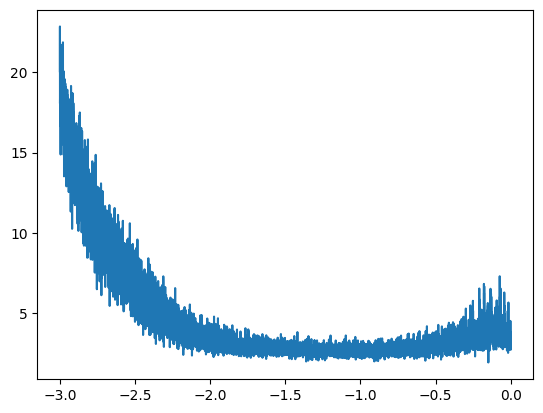

In [84]:
plt.plot(lri, lossi)

The next part of the video deals with splitting out the training data into  training, dev and test split.

In [89]:
# training split, dev/validation split, test split
# 80%, 10%, 10% ... typically.

# build the dataset
# block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [97]:
# this code resets stuff so that we can re-run stuff fresh

epochs = 20000 # Changed!

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((totalCharacters, embeddingWidth), generator=g)
W1 = torch.randn((noOfInputs, noOfNeurons), generator=g)
b1 = torch.randn(noOfNeurons, generator=g)
W2 = torch.randn((noOfNeurons, totalCharacters), generator=g)
b2 = torch.randn(totalCharacters, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [98]:
lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [99]:
lri = []
lossi = []
stepi = []

In [102]:
for i in range(epochs):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batchSize,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, noOfInputs) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())


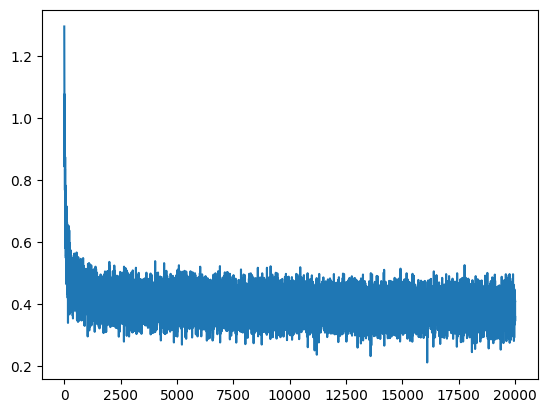

In [103]:
plt.plot(stepi, lossi)